In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [26]:
y.shape

(70000,)

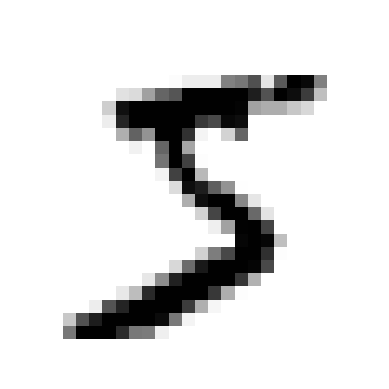

In [42]:
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit = X.iloc(0)[0].to_numpy()
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()
#the image at index 1

In [43]:
#the label at index 1
y[0]

'5'

In [47]:
import numpy as np
#y.to_numpy()
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)


In [48]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(random_state=42)

In [52]:
sgd_clf.predict([some_digit])

c:\Users\manch\anaconda3\envs\hands_on_ml\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [54]:
#measuring perfomance
#we use a custom implementation of cross validation that offers more control over the parameters
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3,scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [55]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) 

False


In [56]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3,scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

In [58]:
#measure of perfomance by confussion matrix
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5,cv=3)


In [59]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [61]:
#evaluating the confusion matrix by  its scores
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 3530 / (687 +3530)

0.8370879772350012

In [62]:

recall_score(y_train_5, y_train_pred) # == 3530 / (1891 +3530)

0.6511713705958311

In [63]:
#evaliuating the  perfomance metric f1 score which is a combination of the precision and the recall of a model
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [73]:
#Increasing precision reduces recall, and vice versa. This is called the precision/recall trade-off.
"""
look at how the SGDClassifier makes its classification decisions.
For each instance, it computes a score based on a decision function. 
If that score is greater than a threshold,
it assigns the instance to the positive class;
otherwise it assigns it to the negative class.
we can use the decision scores to plot the precision/recall trade off.
"""
y_scores = sgd_clf.decision_function([some_digit])
y_scores

c:\Users\manch\anaconda3\envs\hands_on_ml\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [74]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[ True]


In [75]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [76]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,method="decision_function")

In [77]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds =precision_recall_curve(y_train_5, y_scores)

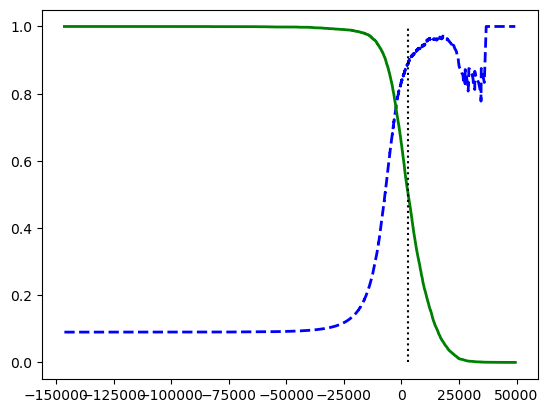

In [78]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision",
linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall",
linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.show()

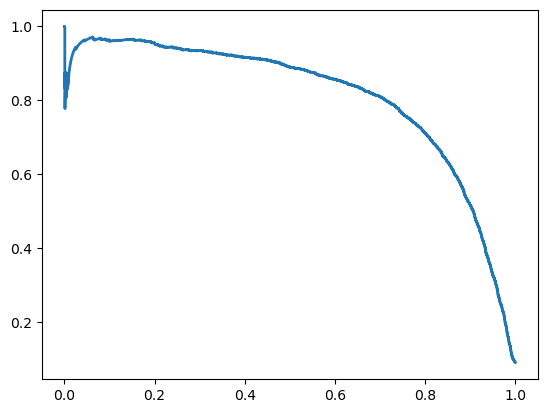

In [79]:
plt.plot(recalls, precisions, linewidth=2,label="Precision/Recall curve")

plt.show()

In [80]:
#find the threshhold that gives you a 90% precision
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [85]:
#you can now make train and make claassifications that have a 90% precision using the threshhold
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
precision_score(y_train_5, y_train_pred_90)



0.9000345901072293

In [86]:
recall_score(y_train_5,y_train_pred_90)


0.4799852425751706

The receiver operating characteristic (ROC) curve is another common tool
used with binary classifiers. 
It is very similar to the precision/recall curve, but instead of plotting precision versus recall,
the ROC curve plots the true positive rate (another name for recall) against the false positive rate (FPR).

The FPR (also called the fall-out) is the ratio of negative instances that are
incorrectly classified as positive.
It is equal to 1 – the true negative rate (TNR), 
which is the ratio of negative instances that are correctly classifiedas negative.
The TNR is also called specificity. 
Hence, the ROC curve plots sensitivity (recall) versus 1 – specificity.
To plot the ROC curve, you first use the roc_curve() function to
compute the TPR and FPR for various threshold values:

In [87]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)


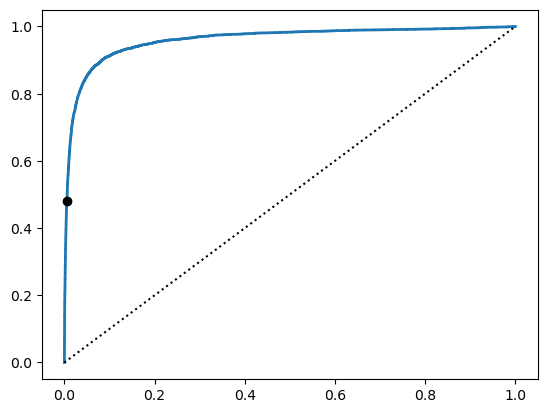

In [91]:
idx_for_threshold_at_90 = (thresholds <=threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90],fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.show()

One way to compare classifiers is to measure the area under the curve
(AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a
purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn
provides a function to estimate the ROC AUC:

In [92]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [93]:
# anew classifier...a random forest classifier
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)


In [94]:
y_probas_forest = cross_val_predict(forest_clf, X_train,y_train_5, cv=3,method="predict_proba")

The precision_recall_curve() function expects labels and scores
for each instance, so we need to train the random forest and make it assign a
score to each instance. But the RandomForestClassifier class does
not have a decision_function() method, due to the way it works
(we will cover this in Chapter 7). Luckily, it has a predict_proba()
method which returns class probabilities for each instance, and we can just
use the probability of the positive class as a score, it will work fine

In [100]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [101]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest =precision_recall_curve(y_train_5, y_scores_forest)

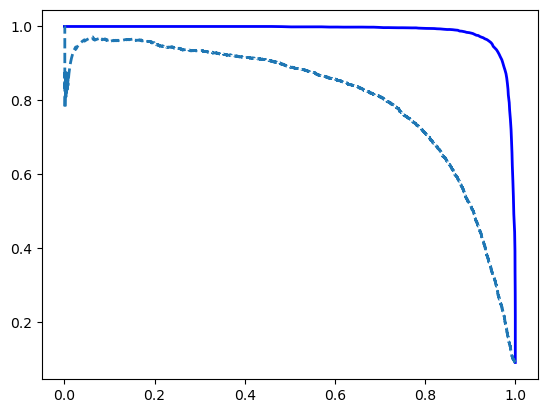

In [102]:
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

plt.show()

In [104]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5 #positive proba ≥ 50%
f1Score=f1_score(y_train_5, y_train_pred_forest)

rocAucScore=roc_auc_score(y_train_5, y_scores_forest)
print(f1Score)
print(rocAucScore)

0.9274509803921569
0.9983436731328145
